Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Geographical and Spatial Analysis

In [4]:
from __future__ import division
import twitter
import nltk
import re
import networkx as nx
import sys
import os
import json
import time
from itertools import chain
import urllib
from datetime import datetime
from datetime import timedelta
import webbrowser
import codecs
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopy.geocoders as gg
from nominatim import Nominatim
import Levenshtein
from bs4 import BeautifulSoup
from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display
#Install http://www.graphviz.org/ & 
#Instal https://pypi.python.org/pypi/pydotplus
import pydotplus

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)
#plt.switch_backend('Agg')

/home/rsouza/.local/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/rsouza/.local/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/rsouza/.local/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/rsouza/.local/lib/python3.5/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Met

#### Specifying the path to the files

In [5]:
templates = "../templates/"
outputs = "../outputs/"

dotfile = "graph_retweet.dot"
pngfile = "graph_retweet.png"
protofile = "graph_retweet.html"
tweetsfile = "Tweets_dump.txt"
template_proto = 'template_protoviz.html'

pathdotfile = os.path.join(outputs,dotfile)
pathpngfile = os.path.join(outputs,pngfile)
pathprotofile = os.path.join(outputs,protofile)
pathtweetsfile = os.path.join(outputs,tweetsfile)
pathtemplate = os.path.join(templates,template_proto)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt + ['',' ','-','rt']

### Using geographical resources within Python

In [6]:
#https://pypi.python.org/pypi/geopy  

gg.OpenMapQuest()
geolocator = gg.GoogleV3()

To geolocate a query to an address and coordinates:

In [7]:
logradouro = "Dona Mario ana, Botafoga" #Note that there are typos in the names
address, (latitude, longitude) = geolocator.geocode(logradouro)
print(address)
print(latitude, longitude)

Rua Dona Mariana - Botafogo, Rio de Janeiro - RJ, Brazil
-22.9529422 -43.1886221


In [8]:
#Measuring editing distances between names:
Levenshtein.ratio('Dona Mariano, Botafoga', 'Rua Dona Mariana - Botafogo')

0.7755102040816326

In [9]:
#https://developers.google.com/maps/documentation/staticmaps/
#http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251
#m – normal map k – satellite h – hybrid p – terrain

def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    google_maps_url = 'http://maps.google.com/maps?q={0}&loc:{1}+{2}&z={3}&t={4}&output=embed'.format(address,
                                                                                                     lat,
                                                                                                     lon,
                                                                                                     zoom,
                                                                                                     tmap,)
    display(IFrame(google_maps_url, '800px', '600px'))
    
gmap(address, latitude, longitude,17,'k')

To find the address corresponding to a set of coordinates:

In [10]:
addresses = geolocator.reverse("-15.798,-47.865")
for address in addresses:
    print(address)

Eixo Monumental, 139 - Brasília, DF, Brazil
Praça dos Três Poderes - Brasília, DF, Brazil
Brasília, Brasilia - Federal District, Brazil
Brasilia, Federal District, Brazil
Asa Sul Entrequadra Sul 414/415 - Brasília, DF, 70297-400, Brazil
Brasilia - Federal District, Brazil
Federal District, Brazil
Brazil


### Using Python and QGIS for geospatial visualizations - a Case Study  
https://www.airpair.com/python/posts/using-python-and-qgis-for-geospatial-visualization  

In [11]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [12]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        shape = row_data[3].text
        duration = row_data[4].text
        data.append((date_time, city, state, shape, duration))
    return data

In [13]:
# get the index page
raw_page = urllib.request.urlopen(index_url)
source = BeautifulSoup(raw_page, "html5lib")
# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like 06/2015
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe201609.html
Processing http://www.nuforc.org/webreports/ndxe201608.html
Processing http://www.nuforc.org/webreports/ndxe201607.html
Processing http://www.nuforc.org/webreports/ndxe201606.html
Processing http://www.nuforc.org/webreports/ndxe201605.html
Processing http://www.nuforc.org/webreports/ndxe201604.html
Processing http://www.nuforc.org/webreports/ndxe201603.html
Processing http://www.nuforc.org/webreports/ndxe201602.html
Processing http://www.nuforc.org/webreports/ndxe201601.html
Processing http://www.nuforc.org/webreports/ndxe201512.html
Processing http://www.nuforc.org/webreports/ndxe201511.html
Processing http://www.nuforc.org/webreports/ndxe201510.html


In [14]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","shape","duration_description"])

In [15]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2016-09-15 02:35:00,Miami,FL,Circle,5 minutes
1,2016-09-14 22:37:00,Highland,MI,Other,10 minutes
2,2016-09-14 22:30:00,Bradenton,FL,Circle,2 minutes
3,2016-09-14 21:30:00,Soringfield,OH,Light,10 seconds
4,2016-09-14 21:10:00,Pittsburgh,PA,Light,20 seconds


In [16]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad', axis=None)
ufos_df = ufos_df.dropna() 

In [17]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2016-09-15 02:35:00,Miami,FL,Circle,5 minutes
1,2016-09-14 22:37:00,Highland,MI,Other,10 minutes
2,2016-09-14 22:30:00,Bradenton,FL,Circle,2 minutes
3,2016-09-14 21:30:00,Soringfield,OH,Light,10 seconds
4,2016-09-14 21:10:00,Pittsburgh,PA,Light,20 seconds


#### Engineering time

In [18]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    text = text.replace('<','')
    text = text.replace('>','')
    text = text.replace('?','')
    text = text.replace('+','')
    text = text.replace('~','')
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour",'Currently']
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600,10]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return 0

In [19]:
# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration_description"].apply(infer_duration_in_seconds)

# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()

In [20]:
ufos_df.head()

,start,city,state,shape,duration_description,duration_secs,end
0,2016-09-15 02:35:00,Miami,FL,Circle,5 minutes,300,2016-09-15 02:40:00
1,2016-09-14 22:37:00,Highland,MI,Other,10 minutes,600,2016-09-14 22:47:00
2,2016-09-14 22:30:00,Bradenton,FL,Circle,2 minutes,120,2016-09-14 22:32:00
3,2016-09-14 21:30:00,Soringfield,OH,Light,10 seconds,10,2016-09-14 21:30:10
4,2016-09-14 21:10:00,Pittsburgh,PA,Light,20 seconds,20,2016-09-14 21:10:20


#### Finding Locations

In [21]:
# http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
# https://github.com/twain47/Nominatim/blob/master/docs/Installation.md
geolocator = Nominatim()

geolocator.query('Newport News')
#geolocator.query("Houston, TX")

[{'boundingbox': ['36.930691', '37.2206658', '-76.6460929', '-76.3616099'],
  'class': 'place',
  'display_name': 'Newport News, Newport News City, Virginia, United States of America',
  'icon': 'http://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png',
  'importance': 0.70997691224355,
  'lat': '37.016827',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
  'lon': '-76.4505195',
  'osm_id': '206655',
  'osm_type': 'relation',
  'place_id': '144553196',
  'type': 'city'},
 {'boundingbox': ['37.0728977', '37.0731352', '-76.478543', '-76.478097'],
  'class': 'amenity',
  'display_name': 'Station 8, Kingstowne Drive, Deer Park, Newport News, Newport News City, Virginia, 23606, United States of America',
  'icon': 'http://nominatim.openstreetmap.org/images/mapicons/amenity_firestation3.p.20.png',
  'importance': 0.201,
  'lat': '37.0730099',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreet

In [22]:
#Be careful with too many queries made to the server in a short period of time

ufos_df["lat"] = 0
ufos_df["lon"] = 0
for i in range(len(ufos_df[0:10])):
    resp_json = geolocator.query(ufos_df['city'][i])
    try:
        ufos_df["lat"][i] = resp_json[0]['lat']
        ufos_df["lon"][i] = resp_json[0]['lon']
    except:
        ufos_df["lat"][i] = 0
        ufos_df["lat"][i] = 0
    time.sleep(1.5)

-c:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
-c:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:12: Setti

In [23]:
# http://stackoverflow.com/questions/17098654/how-to-store-data-frame-using-pandas-python
ufos_df.to_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df = pd.read_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df.head()

,start,city,state,shape,duration_description,duration_secs,end,lat,lon
0,2016-09-15 02:35:00,Miami,FL,Circle,5 minutes,300,2016-09-15 02:40:00,25.7742658,-80.1936588
1,2016-09-14 22:37:00,Highland,MI,Other,10 minutes,600,2016-09-14 22:47:00,57.5066357,-5.0038366
2,2016-09-14 22:30:00,Bradenton,FL,Circle,2 minutes,120,2016-09-14 22:32:00,27.4989278,-82.5748193
3,2016-09-14 21:30:00,Soringfield,OH,Light,10 seconds,10,2016-09-14 21:30:10,0,0
4,2016-09-14 21:10:00,Pittsburgh,PA,Light,20 seconds,20,2016-09-14 21:10:20,40.4416941,-79.990086


In [24]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv(os.path.join(outputs,'ufo_data.csv'),
                                                             index=False, 
                                                             encoding="utf-8")

### Using geographical resources for twitter Analysis

https://github.com/bear/python-twitter (before was http://code.google.com/p/python-twitter/)  
https://dev.twitter.com/docs  

Twitter API Keys  
Please generate yours...  
Go to http://twitter.com/apps/new to create an app and get these items  
See https://dev.twitter.com/docs/auth/oauth for more information on Twitter's OAuth implementation  
https://dev.twitter.com/rest/reference/get/account/verify_credentials  
https://dev.twitter.com/docs/auth/oauth  
https://dev.twitter.com/apps/new  

Inspiration: http://onemilliontweetmap.com/  

In [25]:
with open('twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

Acessing Twitter (with or without authentication)

In [26]:
#api = twitter.Api() # Accessing with no authentication
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret)

In [27]:
print(api.VerifyCredentials())

{"created_at": "Thu Apr 09 10:44:07 +0000 2009", "description": "Researcher and Professor", "favourites_count": 1, "followers_count": 494, "friends_count": 133, "id": 29959702, "lang": "en", "listed_count": 19, "location": "Rio de Janeiro", "name": "Renato Rocha Souza", "profile_background_color": "9AE4E8", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/33941499/8.jpg", "profile_image_url": "http://pbs.twimg.com/profile_images/503088023/Renato2_normal.JPG", "profile_link_color": "0084B4", "profile_sidebar_fill_color": "DDFFCC", "profile_text_color": "333333", "screen_name": "rrsouza", "status": {"created_at": "Mon Jan 05 11:05:11 +0000 2015", "hashtags": [{"text": "FGV"}, {"text": "emap"}], "id": 552058220781797376, "id_str": "552058220781797376", "lang": "und", "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>", "text": "http://t.co/5l4lGVKiBG #FGV #emap", "urls": [{"expanded_url": "http://blog.udacity.com/2014/11/data-s

#### Lexical Analysis

Recent (random) public messages

In [28]:
msgpublicas = api.GetStreamSample()

In [29]:
for i in range(15):
    tweet = next(msgpublicas)
    if 'text' in tweet:
        print(u'{}\n'.format(tweet['text']))

RT @TVShow: Quem está curtindo a reestreia de "Cheias de Charme" no "Vale a Pena Ver De Novo", na Globo? #CheiasDeCharme https://t.co/J6umg…

RT @ChapecoenseReal: Nesta quarta enfrentamos o @Independiente. Maior campeão de Libertadores da história.
Independiente x Chapecoense às 1…

2 people unfollowed me today tracked by https://t.co/MnKDQyDv0j

@d_yourdeath что именно?

โหห เข้าไปในห้องดรีมทีมมา ไม่คุ้นชื่อใครเลยนอกจากไอบอส... งี้แหละ พวกทิ้งแอลไปเล่นเกมอื่น ;__;

RT @merongdks: ชย: เห็นเขานั่งอยู่ก็ถาม ทำอะไร? ก็ไม่ตอบ ถามดีๆไม่ได้พูดเล่นเลยนะครับ
mc: ทำไมไม่ตอบเค้าล่ะครับ https://t.co/Gl2oy80IjH

Nöbetçi GYY davalarının tarihleri. @OzgurGundemGzt1 yöneticileri İnan ve Zana hepsinde sanık. #özgürbasınnöbeti https://t.co/yZ3a1Bc77s

I just checked in at ASA (Automotive Service Association) with #mPLUSPlaces Download today!  https://t.co/ARZc9BNzrE

…………………

RT @tropicary: jsuis pas une fille jcrois alors https://t.co/cNgwAqAnMF

RT @_TheBooster: #HillaryCampaign | LINCOLN UNIVERSITY 

Tweet Structure

In [30]:
while True:
    tweet = next(msgpublicas)
    if 'user' in tweet:
        break
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Sep 19 18:08:49 +0000 2016',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 52416173,
    'id_str': '52416173',
    'indices': [0, 12],
    'name': 'nehad ismail',
    'screen_name': 'nehadismail'}]},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 777932473640558592,
 'id_str': '777932473640558592',
 'in_reply_to_screen_name': 'nehadismail',
 'in_reply_to_status_id': 777932014460600321,
 'in_reply_to_status_id_str': '777932014460600321',
 'in_reply_to_user_id': 52416173,
 'in_reply_to_user_id_str': '52416173',
 'is_quote_status': False,
 'lang': 'ar',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'text': '@nehadismail حياك الله أستاذ نهاد وين أيامك',
 'timestamp_ms': '1474308529659',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'c

In [31]:
Image(url='http://mike.teczno.com/img/raffi-krikorian-map-of-a-tweet.png')

Recent messages from an user

In [32]:
msguser = api.GetUserTimeline(tweet['user']['id'])
print([s.text for s in msguser])

['@nehadismail حياك الله أستاذ نهاد وين أيامك', 'جميل https://t.co/d6aInLCRQh', '@nehadismail هؤلاء مفلسون', 'أتقدم باحر التعازي من ابو الانس ابو عيطه (هادي رجا ابوعيطه) ومحمد(أبو معاذ) ومصطفى(أبو معن) وهائل(أبو ليث)... https://t.co/2eMskhJ6uW', 'النفس تبكي على الدنيا وقد علمت/أن السلامة فيها ترك ما فيها\n-علي بن أبي طالب رضي الله عنه-', 'فلسطين والمؤثرات العربية\nبقلم:سري سمّور\n\nونحن نعيش ذكرى مجزرة مخيمي صبرا وشاتيلا قبل 34 سنة يحضرني مشهد امرأة... https://t.co/RHgsBo9biC', 'فلسطين والمؤثرات العربية https://t.co/9dkchsao5A', 'I posted a new video to Facebook https://t.co/b7pTH0isUf', 'I posted a new video to Facebook https://t.co/vb9bGidrnf', 'مقالان قيد النشر لي بالتزامن:-\n1)فلسطين والمؤثرات العربية...وهو ضمن سلسلة حول الموضوع.\n2)فلنواصل دراسة السيرة.', 'الديموقراطيون فتحوا صنابير أموال الأمريكيين على الكيان العبري في هذا الوقت لضمان أصوات اليهود في الانتخابات،ولكن من سيدعم هؤلاء؟', 'الإنسان أسير الإحسان.', 'لا يمكن النظر إلى التصعيد الحالي بمنظور ميداني عملياتي بحت بمعزل عن الخ

Recent messages from the authenticated user

In [33]:
msguser = api.GetUserTimeline('rrsouza')
#msguser = api.GetUserTimeline('29959702')
print([s.text for s in msguser])

['http://t.co/5l4lGVKiBG #FGV #emap', 'Olá Pessoal! Fiquem atentos à aula de Modelagem e Mineração de Dados... Hoje análises com Twitter!', 'Mais um curioso fenômeno dos nossos tempos: #LeakForJLaw Or maybe #LeakForPerverts ?', 'RT @mashable: 8 Brutally Honest Facebook Notifications That Need to Exist Now http://t.co/wwFQ1hut9x http://t.co/b2GjxcNb6D', '#Cite10CoisasQueSuaMãeFala come alguma coisa antes para não chegar na festa esfomeado', 'Implicações do Big Data para as questões de privacidade: http://t.co/WDJwxpOr9d', 'Resultados da seleção do Mestrado em Modelagem Matemática da Informação - turma 2013 saem nesta sexta, 08/02. #FGV #EMAp', 'RT @PyPLN: We just released the very first version (0.1.0) of pypln.api -- a Python library to programatically access @PyPLN Web! http:/ ...', "Men's Fitness UK by Dennis Publishing Ltd http://t.co/y8YZBBeP", "I'm at Capes (Brasília, DF) w/ 2 others http://t.co/QiukVJqW", "I'm at Capes (Brasília, DF) http://t.co/OfRoPS0y", '@israelst na verdade, 

After authentication, more options are available

In [34]:
userfollow = api.GetFriends()
print([u.name for u in userfollow])

['Lucas Parisi', 'Carla Codeço Coelho', 'Overleaf', 'Cláudio Berrondo', 'Flávio Amieiro', 'Pablo Cerdeira', 'Cut the Rope', 'Machinalis', 'MiningTheSocialWeb', 'CNET News', 'ReadWrite', 'The Next Web 📱💻🌍', 'CNET', 'The Verge', 'Engadget', 'Lifehacker', 'Gizmodo', 'WIRED', 'TechCrunch', 'Ian Ozsvald', 'CNPq', 'Claudio Gnoli', 'strongsteam', 'Diana Maynard', 'Joyce Figueiró', 'Álvaro Justen', 'PyPLN', 'Open Source For You', 'TechRepublic', 'ZDNet', 'Twitter API', 'Udacity', 'Clarissa', 'Roberto R.S.Sobrinho', 'Luana Sales', 'Sensacionalista', 'André Branco', 'CMA', 'Asla Sá', 'Renata Teixeira', 'FGV EMAp', 'FGV', 'FGV Marketing', 'CPDOC', 'Globant Brasil', 'Sheffield NLP', 'Débora Pereira', 'André Andrade', "O'Reilly Radar", 'Virgilio Almeida', 'Dalai Lama', 'Alexandre Colucci', 'Benildes Maculan', 'Gabriel Rezende', 'Mashable', 'alfredo hirsch', 'Fernando S Parreiras', 'NYTimes Bits', 'MiniCursos', 'Googleverse', 'Hootsuite', 'G1 - Concursos', 'Ivana', 'Dina Araujo', 'João Batista', 'W3

Searching for a term in tweets

In [35]:
def search_for_term(termo, pages, results):
    '''Search and return tweets on a subject (5 pages of 100 results each)
    Save results in a file defined in "pathtweetsfile" '''
    search_results = []
    tweets = []
    tweets_txt = []
    tweets_words = []
    names = []
    last = api.GetSearch(term=termo, count=1)
    search_results.append(last)
    list_ids = []
    list_ids.append(last[0].id)
    for i in range(pages):
        id_last = last[0].id
        new_tweets = api.GetSearch(term=termo, count=results, max_id=min(list_ids))
        for i in range(len(new_tweets)):
            list_ids.append(new_tweets[i].id)
        search_results.append(new_tweets)
    for i in range(len(search_results)):
        for j in range(len(search_results[i])):
            tweets.append(search_results[i][j])
    tweets_txt += [tweet.text.split(u' ') for tweet in tweets]
    for i in range(len(tweets)):
        tweets_words += [word.lower().strip(u':@&$!?') for word in tweets_txt[i]]
    for i in range(len(tweets)): 
        names += [word.strip(u':@&$!?') for word in tweets_txt[i] if word.istitle() and len(word) > 2]
    with open(pathtweetsfile,'w') as out:
        for tweet in tweets_txt:
            out.write(u'\n{}'.format(tweet))
    return tweets, tweets_txt, tweets_words, names

def lexical_diversity(text):
    return len(text) / len(set(text))

In [36]:
twitter_query = u'hillary'

search = api.GetSearch(twitter_query)
print([s.text for s in search])

['"We have got to do everything we can to make sure that Hillary Clinton is elected president." —@BernieSanders https://t.co/t1uxcoVJT5', "Remember that time Michelle Obama used Bill Clinton's cheating to say Hillary shouldn't be President?  I do. https://t.co/zi6DywEHtF", "Hillary Clinton's weakness while she was Secretary of State, has emboldened terrorists all over the world..cont: https://t.co/E5BdTiwlur", 'Obama &amp; Hillary both praise the authorities in the NY/NJ bombing. Polls must really be down.', "Hillary Clinton: Here's what millennials have taught me  https://t.co/6tFZFIPb2B via @Mic", 'RT @just_jenna: "First of all I would like you to know (if you don\'t know already) that you are awesome." - Hayley to Hillary https://t.co/…', 'RT @JudgeJeanine: Hillary, I know you have double-vision and memory problems—documented by the FBI—but your hypocrisy is stunning. https://…', 'RT @mic: .@HillaryClinton wrote for us about what millennials have taught her during this election: htt

Using our customized function that retrieves 5 x 100 tweets

In [37]:
tweets, tweets_txt, tweets_words, names = search_for_term(twitter_query,5,10)
    
print('Word count: {}'.format(len(tweets_words)))
print('Repertoire: {}'.format(len(set(tweets_words))))
print('Lexical diversity: {}'.format(lexical_diversity(tweets_words)))

Word count: 819
Repertoire: 384
Lexical diversity: 2.1328125


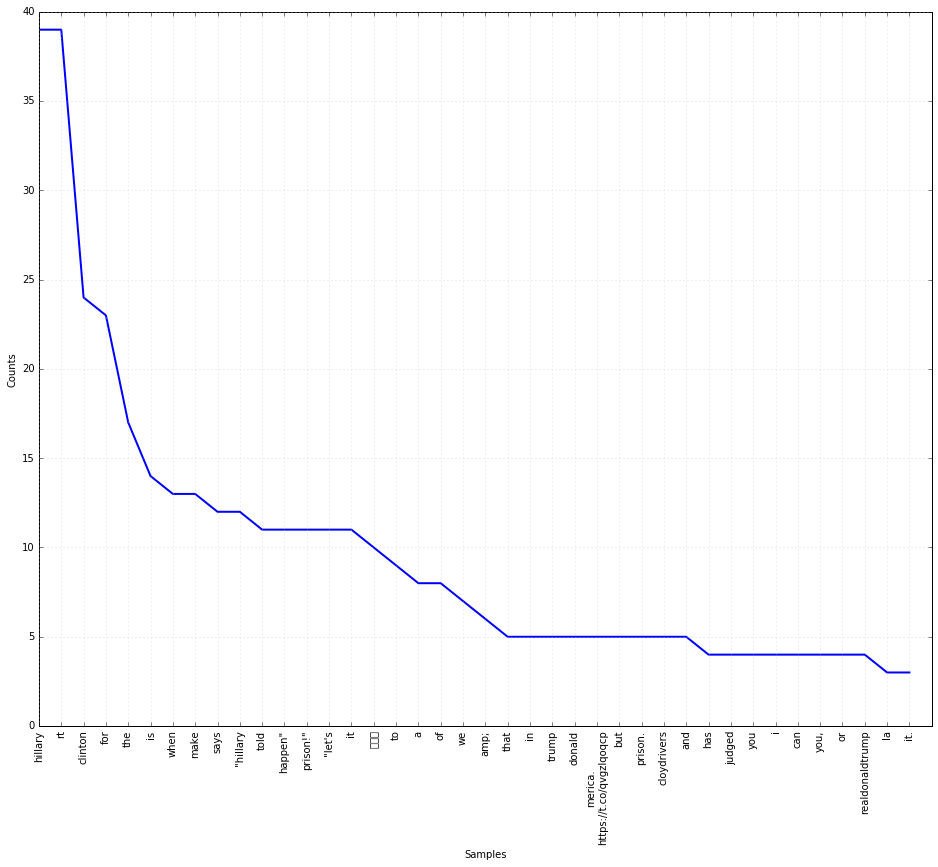

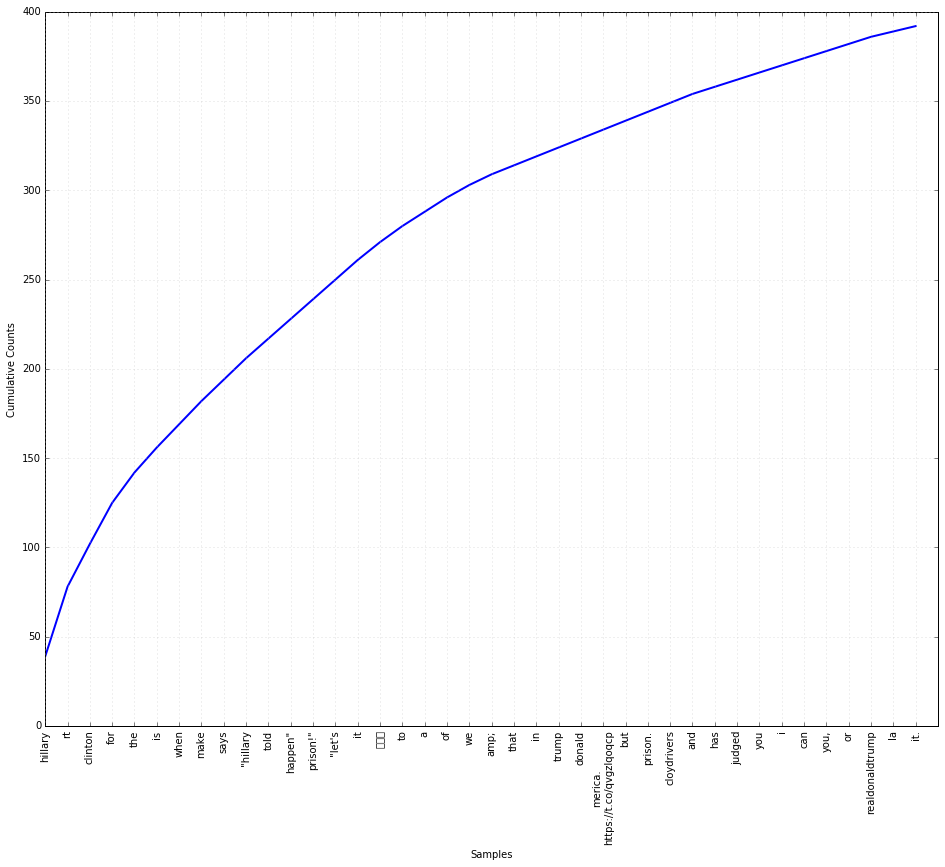

In [38]:
freq_dist = nltk.FreqDist(tweets_words)
freq_dist.plot(40)
freq_dist.plot(40, cumulative = True)

In [39]:
#print('10 most frequent words')
print(freq_dist.most_common())

[('hillary', 39), ('rt', 39), ('clinton', 24), ('for', 23), ('the', 17), ('is', 14), ('when', 13), ('make', 13), ('says', 12), ('"hillary', 12), ('told', 11), ('happen"', 11), ('prison!"', 11), ('"let\'s', 11), ('it', 11), ('😂😁😂', 10), ('to', 9), ('a', 8), ('of', 8), ('we', 7), ('amp;', 6), ('that', 5), ('in', 5), ('trump', 5), ('donald', 5), ('merica.\nhttps://t.co/qvgzlqoqcp', 5), ('but', 5), ('prison.', 5), ('cloydrivers', 5), ('and', 5), ('has', 4), ('judged', 4), ('you', 4), ('i', 4), ('can', 4), ('you,', 4), ('or', 4), ('realdonaldtrump', 4), ('la', 3), ('it.', 3), ('her', 3), ('against', 3), ('#hillary', 3), ("don't", 3), ('by', 3), ('from', 3), ('everything', 2), ('out', 2), ('https://t.co/zotaj3hxvc', 2), ('https://t.co/aliouka8ub', 2), ('poll', 2), ('so', 2), ('got', 2), ('https://t.co/vhog…', 2), ('do', 2), ('voxdotcom', 2), ('helping', 2), ('if', 2), ('2016', 2), ('"thank', 2), ('obama', 2), ('elected', 2), ('was', 2), ('htt…', 2), ('happen', 2), ('whole', 2), ('shows', 2),

In [40]:
print('Sorted list of words')
print(sorted(set(tweets_words)))

Sorted list of words
['', '\n\nwatch👉🏽\nh…', '"banquete",', '"hillary', '"let\'s', '"recalentado"', '"stronger', '"thank', '"we', '#clinton,', '#emmys\xa0', '#georgeclooney', '#hillary', '#maga', '#msm', '#méxico,', '#nycexplosion', '#poll', '#sudan', '#thesentry', '#trump', '#trump2016', '-', '18,', '2016', '60%', 'a', 'about', 'address', 'advantages', 'against', 'agenda）座谈会上发表演讲，美国华盛顿。9月12…', 'all', 'allegations', 'amazon', 'amp;', 'and', 'anything,', 'are', 'as', 'asks', 'assigned', 'attacked', 'award', 'backing', 'bad', 'badly.', 'becom…', 'bernie', 'best', 'biackppicomedy', 'biggest', 'bigotry', 'bin', 'black', 'blackpplvines', 'blisstabitha', 'book', 'brianstelter', 'buena', 'but', 'buyout', 'by', 'call', 'campaign', 'campaigning', 'campaign💥\n\n😱shocking', 'can', 'candidate', 'carter', 'cbs', 'cfr_org', 'charity', 'children', 'china', 'china,', 'chung.', 'clinton', 'clinton\n\nhttps://t.co/yxklhtltah', 'clinton"', 'clinton.', 'clintonfdn', 'clinton’s', 'cloydrivers', 'comes', 'c

Same as before, without stopwords. See variable "ignorewords"

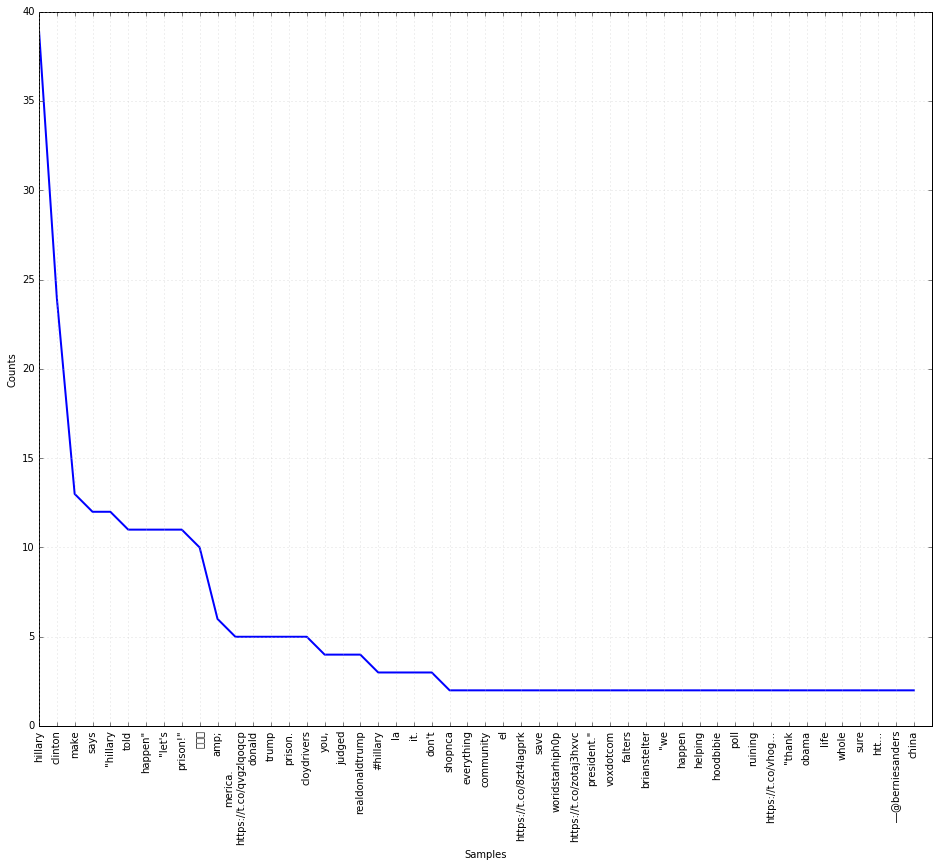

In [41]:
new_tweets_words = [word for word in tweets_words if word not in ignorewords]
    
freq_new = nltk.FreqDist(new_tweets_words)    
freq_new.plot(50)

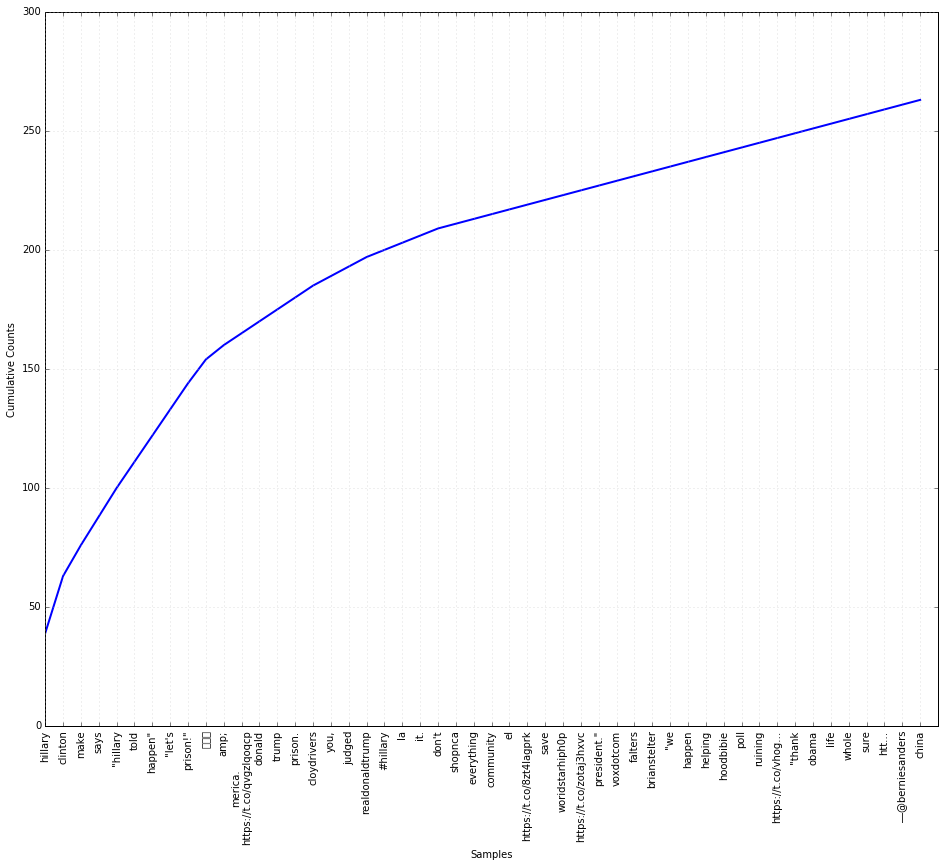

In [42]:
freq_new.plot(50, cumulative = True)

In [43]:
print('10 most frequent words')
print(freq_new.most_common())

10 most frequent words
[('hillary', 39), ('clinton', 24), ('make', 13), ('says', 12), ('"hillary', 12), ('told', 11), ('happen"', 11), ('"let\'s', 11), ('prison!"', 11), ('😂😁😂', 10), ('amp;', 6), ('merica.\nhttps://t.co/qvgzlqoqcp', 5), ('donald', 5), ('trump', 5), ('prison.', 5), ('cloydrivers', 5), ('you,', 4), ('judged', 4), ('realdonaldtrump', 4), ('#hillary', 3), ('la', 3), ('it.', 3), ("don't", 3), ('shopnca', 2), ('everything', 2), ('community', 2), ('el', 2), ('https://t.co/8zt4lagprk', 2), ('save', 2), ('woridstarhiph0p', 2), ('https://t.co/zotaj3hxvc', 2), ('president."', 2), ('voxdotcom', 2), ('falters', 2), ('brianstelter', 2), ('"we', 2), ('happen', 2), ('helping', 2), ('hoodbibie', 2), ('poll', 2), ('ruining', 2), ('https://t.co/vhog…', 2), ('"thank', 2), ('obama', 2), ('life', 2), ('whole', 2), ('sure', 2), ('htt…', 2), ('—@berniesanders', 2), ('china', 2), ('worldstarc0medy', 2), ('https://t.co/t1uxcovjt5', 2), ('skyrocketing', 2), ('clinton"', 2), ('destroy', 2), ('tim

In [44]:
print('Sorted list of words')
print(sorted(set(new_tweets_words)))

Sorted list of words
['\n\nwatch👉🏽\nh…', '"banquete",', '"hillary', '"let\'s', '"recalentado"', '"stronger', '"thank', '"we', '#clinton,', '#emmys\xa0', '#georgeclooney', '#hillary', '#maga', '#msm', '#méxico,', '#nycexplosion', '#poll', '#sudan', '#thesentry', '#trump', '#trump2016', '18,', '2016', '60%', 'address', 'advantages', 'agenda）座谈会上发表演讲，美国华盛顿。9月12…', 'allegations', 'amazon', 'amp;', 'anything,', 'asks', 'assigned', 'attacked', 'award', 'backing', 'bad', 'badly.', 'becom…', 'bernie', 'best', 'biackppicomedy', 'biggest', 'bigotry', 'bin', 'black', 'blackpplvines', 'blisstabitha', 'book', 'brianstelter', 'buena', 'buyout', 'call', 'campaign', 'campaigning', 'campaign💥\n\n😱shocking', 'candidate', 'carter', 'cbs', 'cfr_org', 'charity', 'children', 'china', 'china,', 'chung.', 'clinton', 'clinton\n\nhttps://t.co/yxklhtltah', 'clinton"', 'clinton.', 'clintonfdn', 'clinton’s', 'cloydrivers', 'comes', 'commerceoig', 'community', 'confuse', 'corruption', 'could', 'crooked', 'cuban', '

Counting specific words

In [45]:
print(new_tweets_words.count('poll'))
print(freq_new['voters']) #same as before
print(freq_new.freq('virginia')) #relative to the others

2
0
0.0


Eliminating small words or words with specific sizes

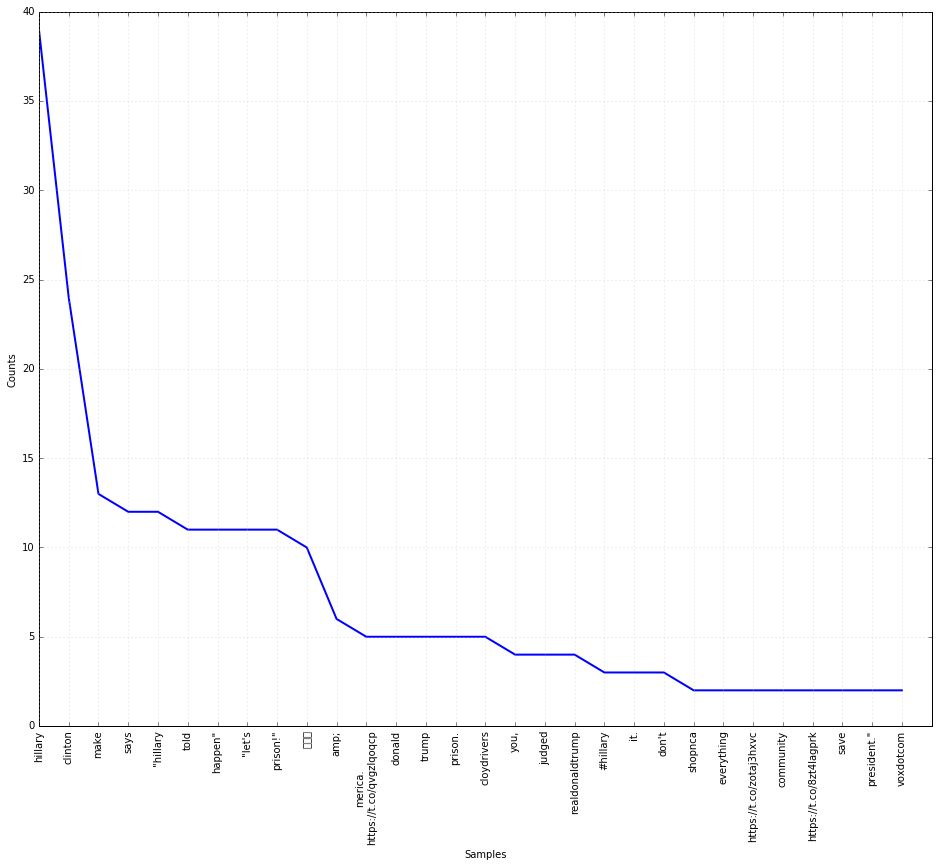

In [46]:
bigger_tweets_words = [word for word in new_tweets_words if len(word) > 2]
#mediumsized_tweets_words = [word for word in new_tweets_words if len(word) > 2 and len(word) < 9]
freq_bigger = nltk.FreqDist(bigger_tweets_words)    
freq_bigger.plot(30)

Citation Analysis

In [47]:
citacoes = [word for word in tweets_words if '@' in word]
#citacoes = [word for word in tweets_words if word.startswith('@')]
freq_citacoes = nltk.FreqDist(citacoes)
freq_citacoes.items()

dict_items([('—@berniesanders', 2)])

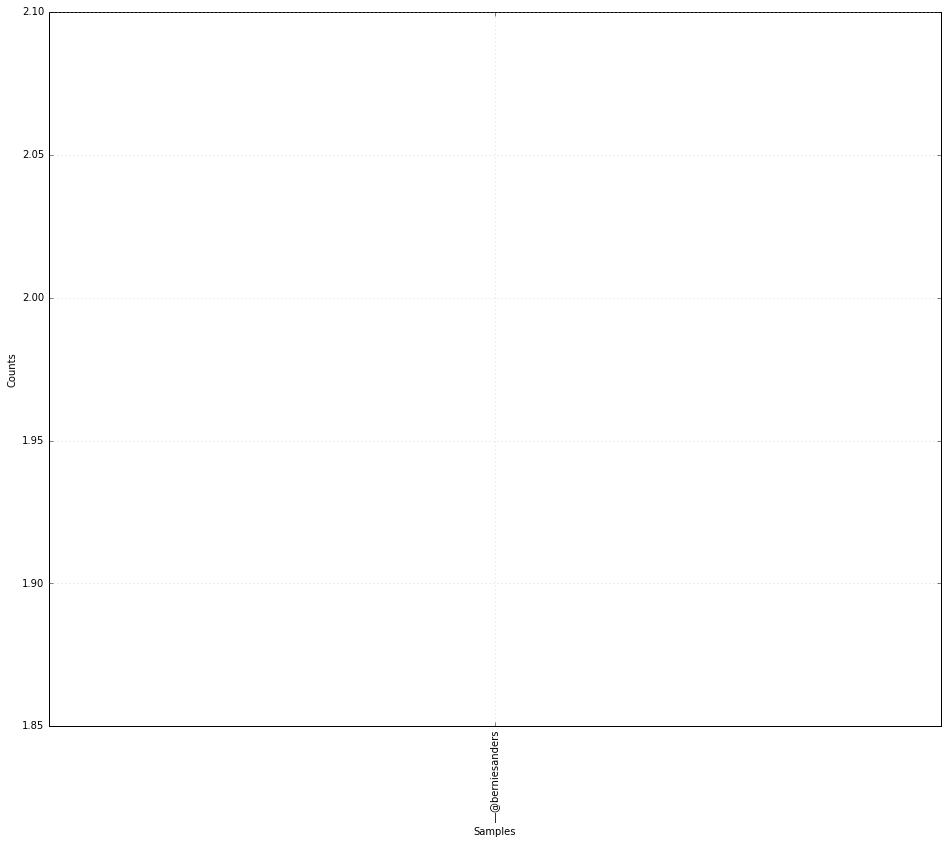

In [48]:
freq_citacoes.plot()

Hashtag Analysis

In [49]:
hashtags = [word for word in tweets_words if word.startswith('#')]
freq_hashtags = nltk.FreqDist(hashtags)
freq_hashtags.items()

dict_items([('#thesentry', 1), ('#méxico,', 1), ('#trump', 1), ('#emmys\xa0', 1), ('#msm', 1), ('#trump2016', 1), ('#georgeclooney', 1), ('#hillary', 3), ('#maga', 1), ('#poll', 1), ('#clinton,', 1), ('#sudan', 1), ('#nycexplosion', 1)])

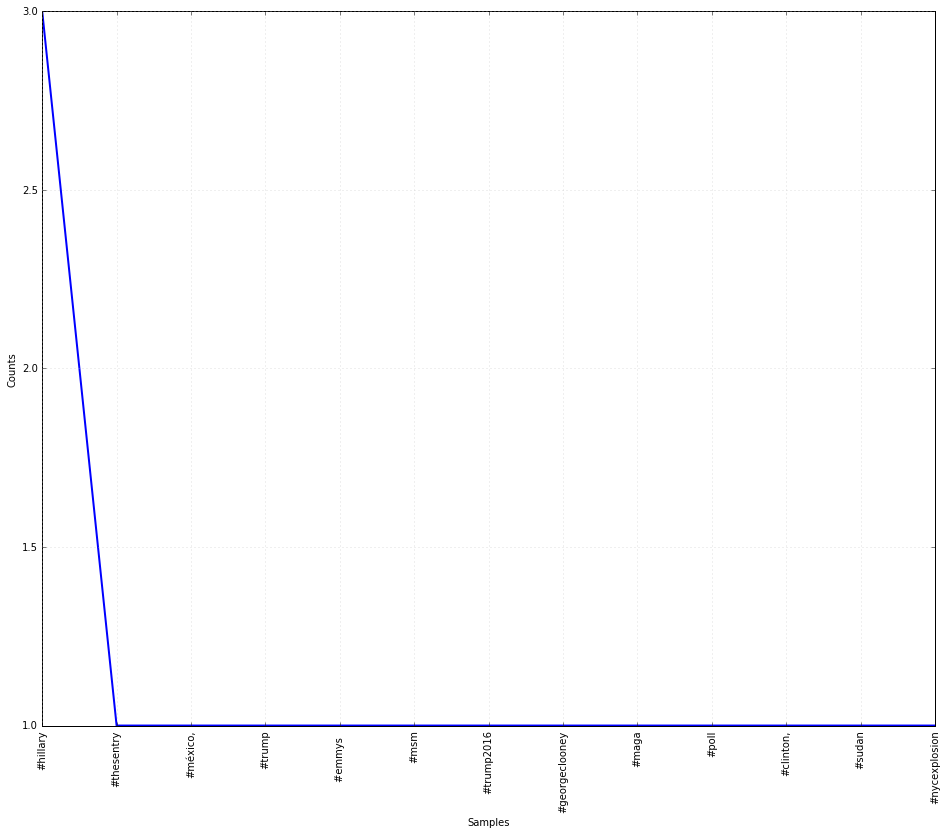

In [50]:
freq_hashtags.plot()

Analysis of Frequent words  
Can be used with any of the previous lists'''

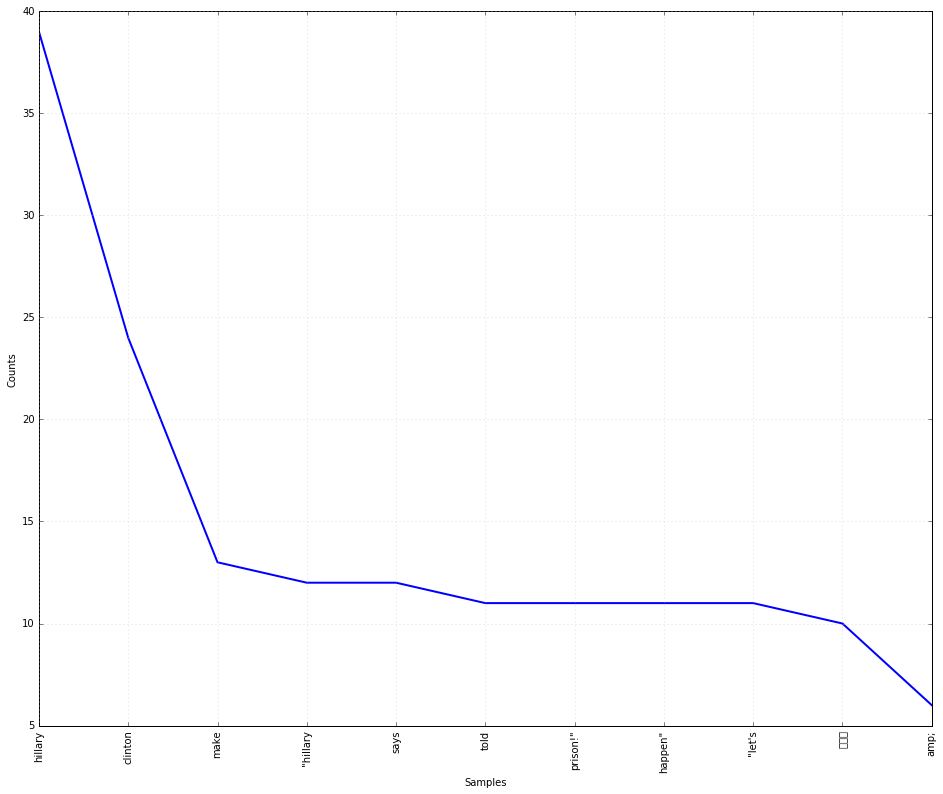

In [51]:
frequent_words = [word.lower() for word in new_tweets_words if tweets_words.count(word) > 5]
freq_dist2 = nltk.FreqDist(frequent_words)
freq_dist2.plot(40)

Words Sizes

In [52]:
freq_size_words = nltk.FreqDist([len(w) for w in new_tweets_words])
freq_size_words.items()

dict_items([(32, 1), (1, 5), (2, 10), (3, 34), (4, 94), (5, 60), (6, 53), (7, 118), (8, 49), (9, 28), (10, 17), (11, 15), (12, 15), (13, 5), (14, 8), (15, 17), (18, 3), (20, 1), (23, 27), (27, 1), (31, 6)])

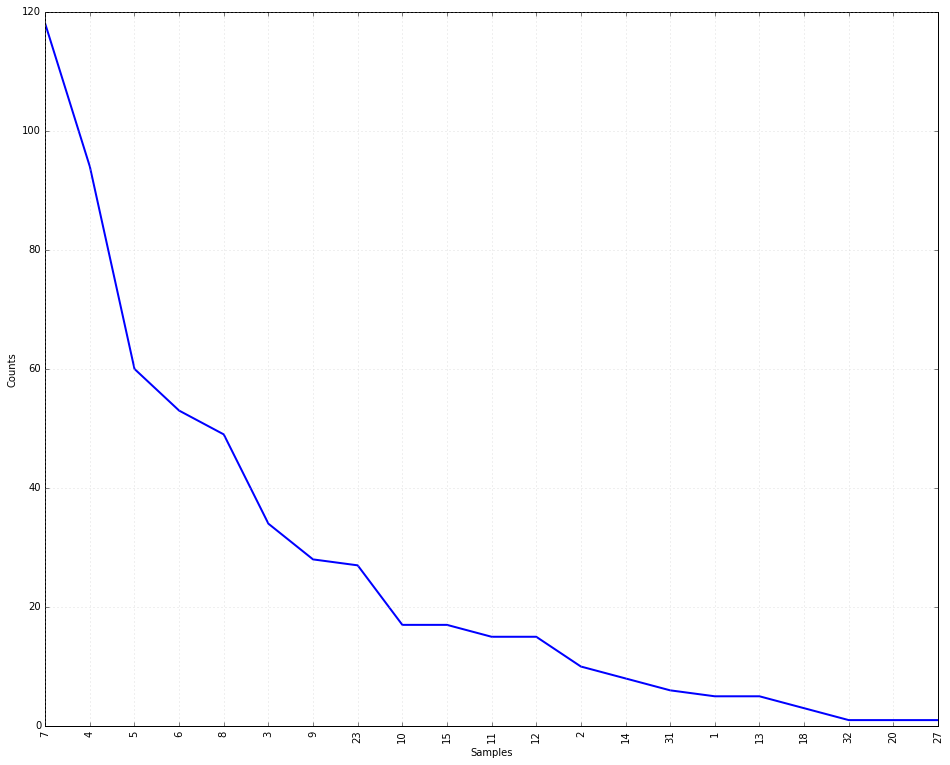

In [53]:
freq_size_words.plot()

Bigrams

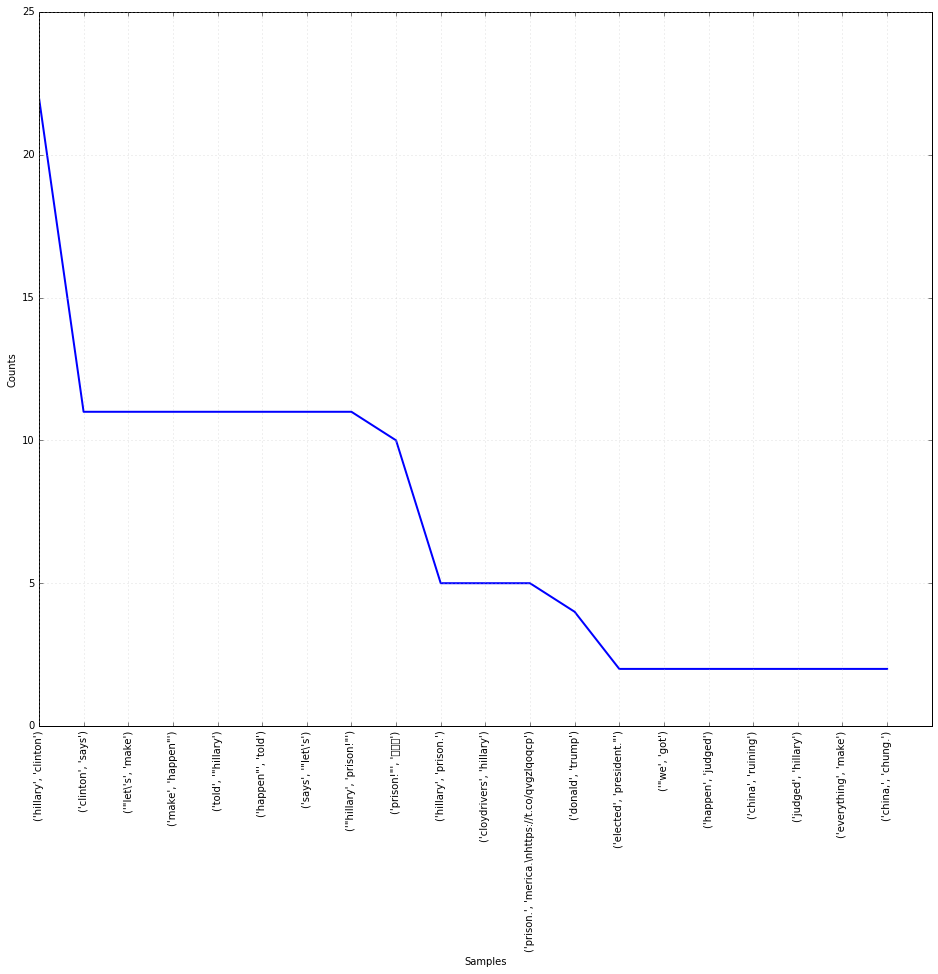

In [54]:
bigramas_tweets = nltk.bigrams(new_tweets_words)
freqbig = nltk.FreqDist(bigramas_tweets)
freqbig.plot(20)

Names (capitalized words)

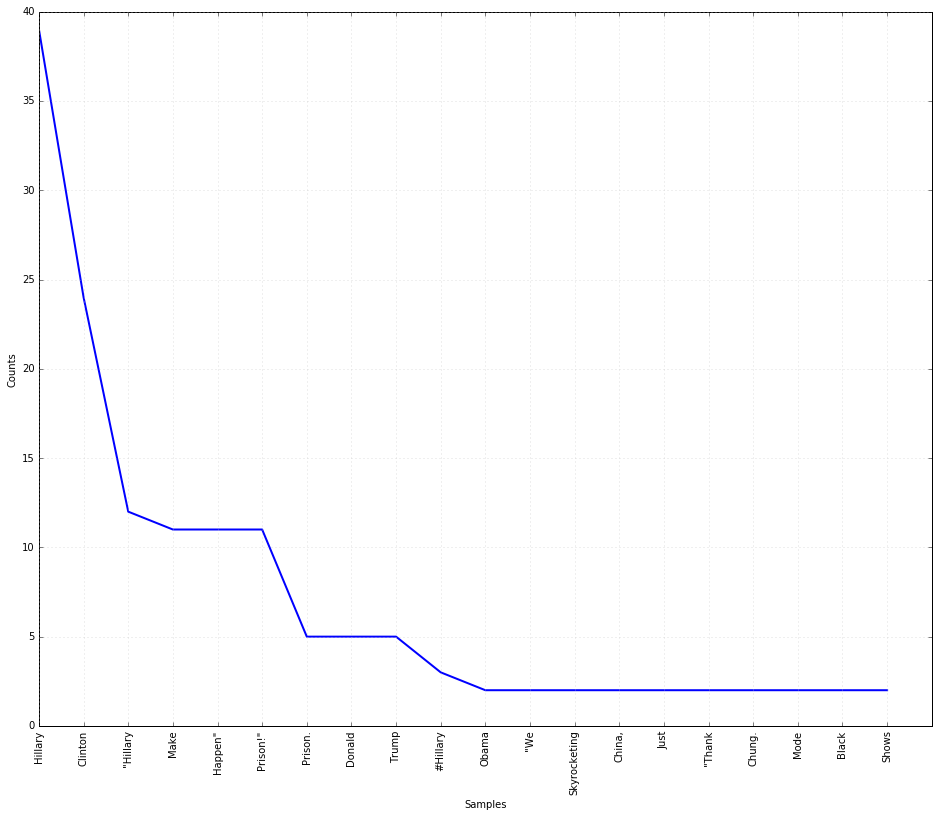

In [55]:
freq_names = nltk.FreqDist(names)
freq_names.plot(20)

#### Sentiment Analysis

In [56]:
badwords =   ['abandoned','abused','accused','addicted','afraid','aggravated',
              'aggressive','alone','angry','anguish','annoyed','anxious','apprehensive',
              'argumentative','artificial','ashamed','assaulted','at a loss','at risk',
              'atrocious','attacked','avoided','awful','awkward','bad','badgered','baffled',
              'banned','barren','beat','beaten down','belittled','berated','betrayed',
              'bitched at','bitter','bizzare','blacklisted','blackmailed','blamed','bleak',
              'blown away','blur','bored','boring','bossed-around','bothered','bothersome',
              'bounded','boxed-in','broken','bruised','brushed-off','bugged','bullied',
              'bummed','bummed out','burdened','burdensome','burned','burned-out',
              'caged in','careless','chaotic','chased','cheated','cheated on','chicken',
              'claustrophobic','clingy','closed','clueless','clumsy','coaxed',
              'codependent','coerced','cold','cold-hearted','combative','commanded',
              'compared','competitive','compulsive','conceited','concerned',
              'condescended to','confined','conflicted','confronted','confused',
              'conned','consumed','contemplative','contempt','contentious','controlled',
              'convicted','cornered','corralled','cowardly','crabby','cramped','cranky',
              'crap','crappy','crazy','creeped out','creepy','critical','criticized',
              'cross','crowded','cruddy','crummy','crushed','cut-down','cut-off','cynical',
              'damaged','damned','dangerous','dark','dazed','dead','deceived','deep',
              'defamed','defeated','defective','defenseless','defensive','defiant',
              'deficient','deflated','degraded','dehumanized','dejected','delicate',
              'deluded','demanding','demeaned','demented','demoralized','demotivated',
              'dependent','depleted','depraved','depressed','deprived','deserted',
              'deserving of pain/punishment','desolate','despair','despairing',
              'desperate','despicable','despised','destroyed','destructive',
              'detached','detest','detestable','detested','devalued','devastated',
              'deviant','devoid','diagnosed','dictated to','different','difficult',
              'directionless','dirty','disabled','disagreeable','disappointed',
              'disappointing','disapproved of','disbelieved','discardable','discarded',
              'disconnected','discontent','discouraged','discriminated','disdain',
              'disdainful','disempowered','disenchanted','disgraced','disgruntled',
              'disgust','disgusted','disheartened','dishonest','dishonorable',
              'disillusioned','dislike','disliked','dismal','dismayed','disorganized',
              'disoriented','disowned','displeased','disposable','disregarded',
              'disrespected','dissatisfied','distant','distracted','distraught',
              'distressed','disturbed','dizzy','dominated','doomed','double-crossed',
              'doubted','doubtful','down','down and out','down in the dumps',
              'downhearted','downtrodden','drained','dramatic','dread','dreadful',
              'dreary','dropped','drunk','dry','dumb','dumped','dumped on','duped',
              'edgy','egocentric','egotistic','egotistical','elusive','emancipated',
              'emasculated','embarrassed','emotional','emotionless','emotionally bankrupt',
              'empty','encumbered','endangered','enraged','enslaved','entangled','evaded',
              'evasive','evicted','excessive','excluded','exhausted','exploited','exposed',
              'fail','failful','fake','false','fear','fearful','fed up','flawed','forced',
              'forgetful','forgettable','forgotten','fragile','freaked out','frightened',
              'frigid','frustrated','furious','gloomy','glum','gothic','grey','grief','grim',
              'gross','grossed-out','grotesque','grouchy','grounded','grumpy','guilt-tripped',
              'guilty','harassed','hard','hard-hearted','harmed','hassled','hate','hateful',
              'hatred','haunted','heartbroken','heartless','heavy-hearted','helpless',
              'hesitant','hideous','hindered','hopeless','horrible','horrified','horror',
              'hostile','hot-tempered','humiliated','hung up','hung over','hurried','hurt',
              'hysterical','idiot','idiotic','ignorant','ignored','ill','ill-tempered',
              'imbalanced','imposed-upon','impotent','imprisoned','impulsive','in the dumps',
              'in the way','inactive','inadequate','incapable','incommunicative','incompetent',
              'incompatible','incomplete','incorrect','indecisive','indifferent',
              'indoctrinated','inebriated','ineffective','inefficient','inferior',
              'infuriated','inhibited','inhumane','injured','injusticed','insane',
              'insecure','insignificant','insincere','insufficient','insulted',
              'intense','interrogated','interrupted','intimidated','intoxicated',
              'invalidated','invisible','irrational','irritable','irritated',
              'isolated','jaded','jealous','jerked around','joyless','judged',
              'kept apart','kept away','kept in','kept out','kept quiet','labeled',
              'laughable','laughed at','lazy','leaned on','lectured to','left out',
              'let down','lied about','lied to','limited','little','lonely','lonesome',
              'longing','lost','lousy','loveless','low','mad','made fun of','man handled',
              'manipulated','masochistic','messed with','messed up','messy','miffed',
              'miserable','misled','mistaken','mistreated','mistrusted','misunderstood',
              'mixed-up','mocked','molested','moody','nagged','needy','negative',
              'nervous','neurotic','nonconforming','numb','nuts','nutty','objectified',
              'obligated','obsessed','obsessive','obstructed','odd','offended',
              'on display','opposed','oppressed','out of place','out of touch',
              'over-controlled','over-protected','overwhelmed','pain','panic','paranoid',
              'passive','pathetic','pessimistic','petrified','phony','picked on','pissed',
              'pissed off','plain','played with','pooped','poor','powerless','pre-judged',
              'preached to','preoccupied','predjudiced','pressured','prosecuted',
              'provoked','psychopathic','psychotic','pulled apart','pulled back',
              'punished','pushed','pushed away','put down','puzzled','quarrelsome',
              'queer','questioned','quiet','rage','raped','rattled','regret','rejected',
              'resented','resentful','responsible','retarded','revengeful','ridiculed',
              'ridiculous','robbed','rotten','sad','sadistic','sarcastic','scared',
              'scarred','screwed','screwed over','screwed up','self-centered','self-conscious',
              'self-destructive','self-hatred','selfish','sensitive','shouted at','shy',
              'singled-out','slow','small','smothered','snapped at','spiteful','stereotyped',
              'strange','stressed','stretched','stuck','stupid','submissive','suffering',
              'suffocated','suicidal','superficial','suppressed','suspicious','worse','worst'
              ,'bankrupcy','jobs','shit','#sob']

In [57]:
goodwords =  ['Abundant','Accomplished','Achieving','Active','Admirable','Adorable',
              'Adventurous','Admired','Affluent','Agreeable','Alert','Aligned','Alive',
              'Amazing','Appealing','Appreciate','Artistic','Astounding','Astute',
              'Attentive','Attractive','Auspicious','Authentic','Awake','Aware','Awesome',
              'Beaming','Beautiful','Better','Best','Blessed','Bliss','Bold','Bright','Brilliant',
              'Brisk','Buoyant','Calm','Capable','Centered','Certain','Charming',
              'Cheerful','Clear','Clever','Competent','Complete','Confident','Connected',
              'Conscious','Considerate','Convenient','Courageous','Creative','Daring',
              'Dazzling','Delicious','Delightful','Desirable','Determined','Diligent',
              'Discerning','Discover','Dynamic','Eager','Easy','Efficient','Effortless',
              'Elegant','Eloquent','Energetic','Endless','Enhancing','Engaging','Enormous'
              ,'Enterprising','Enthusiastic','Enticing','Excellent','Exceptional','Exciting'
              ,'Experienced','Exquisite','Fabulous','Fair','Far-Sighted','Fascinating',
              'Fine','Flattering','Flourishing','Fortunate','Free','Friendly','Fulfilled',
              'Fun','Generous','Genuine','Gifted','Glorious','Glowing','Good','Good-Looking',
              'Gorgeous','Graceful','Gracious','Grand','Great','Handsome','Happy','Hardy',
              'Harmonious','Healed','Healthy','Helpful','Honest','Humorous','Ideal',
              'Imaginative','Impressive','Industrious','Ingenious','Innovative','Inspired',
              'Intelligent','Interested','Interesting','Intuitive','Inventive','Invincible',
              'Inviting','Irresistible','Joyous','Judicious','Keen','Kind','Knowing','Leader',
              'Limitless','Lively','Loving','Lucky','Luminous','Magical','Magnificent',
              'Marvellous','Masterful','Mighty','Miraculous','Motivated','Natural','Neat',
              'Nice','Nurturing','Noble','Optimistic','Outstanding','Passionate','Peaceful',
              'Perfect','Persevering','Persistent','Playful','Pleasing','Plentiful','Positive',
              'Powerful','Precious','Prepared','Productive','Profound','Prompt','Prosperous',
              'Proud','Qualified','Quick','Radiant','Reasonable','Refined','Refreshing',
              'Relaxing','Reliable','Remarkable','Resolute','Resourceful','Respected',
              'Rewarding','Robust','Safe','Satisfied','Secure','Seductive','Self-Reliant',
              'Sensational','Sensible','Sensitive','Serene','Sharing','Skilful','Smart',
              'Smashing','Smooth','Sparkling','Spiritual','Splendid','Strong','Stunning',
              'Successful','Superb','Swift','Talented','Tenacious','Terrific','Thankful',
              'Thrilling','Thriving','Timely','Trusting','Truthful','Ultimate','Unique',
              'Valiant','Valuable','Versatile','Vibrant','Victorious','Vigorous','Vivacious',
              'Vivid','Warm','Wealthy','Well','Whole','Wise','Wonderful','Worthy','Young',
              'Youthful','Zeal','Zest']

In [58]:
def percentage(count, total):
    return 100 * count / float(total)

In [59]:
def sentiment_analysis(texto, goodwords, badwords):
    '''
    Not a sophisticated one, but the main idea is present.
    Please read: http://alias-i.com/lingpipe/demos/tutorial/sentiment/read-me.html
    '''
    goodness = 0
    badness = 0    
    for word in goodwords:
        goodness += percentage(texto.count(word.lower()), len(texto))
    for word in badwords:
        badness += percentage(texto.count(word.lower()), len(texto))
    if badness:
        ratio = goodness/float(badness)
    print(u'Grau de negatividade: {}'.format(badness))
    print(u'Grau de positividade: {}'.format(goodness))
    if badness:
        print(u'Razão: {}'.format(ratio))
    return goodness, badness

In [60]:
sentiment_analysis(tweets_words, goodwords, badwords);

Grau de negatividade: 1.2210012210012209
Grau de positividade: 0.6105006105006104
Razão: 0.5


#### Geographic Analysis

https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb  

In [61]:
#http://matplotlib.org/basemap/api/basemap_api.html
from mpl_toolkits.basemap import Basemap

In [62]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 20:
    tweet = next(msgpublicas)
    if 'coordinates' in tweet.keys() and tweet['coordinates'] != None:
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'Usuário {} nas coordenadas {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

Usuário 175262833 nas coordenadas [37.53110494, -77.59367542]
Usuário 328235332 nas coordenadas [45.47646, 9.16831]
Usuário 714404437 nas coordenadas [39.1031182, -84.5120196]
Usuário 307225438 nas coordenadas [14.5591055, 121.00848322]
Usuário 35893054 nas coordenadas [29.5849108, -98.6170659]
Usuário 89539596 nas coordenadas [40.7142, -74.0064]
Usuário 969149072 nas coordenadas [50.0, 36.25]
Usuário 901543512 nas coordenadas [38.43784397, 27.14414835]
Usuário 142430086 nas coordenadas [29.37826284, 47.99262758]
Usuário 4859035943 nas coordenadas [38.5702356, -76.0868338]
Usuário 2924224280 nas coordenadas [39.1918828, -78.205951]
Usuário 376084009 nas coordenadas [6.45993964, 3.19422661]
Usuário 567544904 nas coordenadas [41.0517005, -73.5366845]
Usuário 22158864 nas coordenadas [39.9082312, -86.267139]
Usuário 59912224 nas coordenadas [41.5616176, -90.583638]
Usuário 72085114 nas coordenadas [-28.02418737, -48.62006312]
Usuário 1408370630 nas coordenadas [9.0846, 8.6742]
Usuário 161

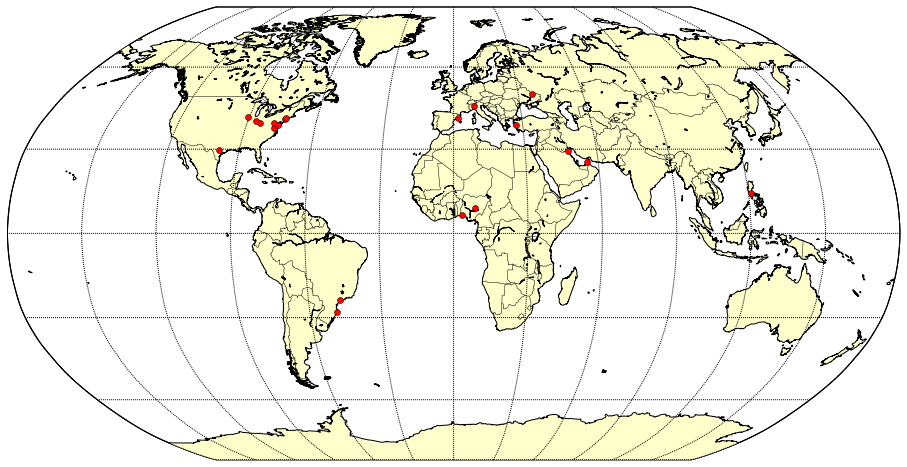

In [63]:
map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#FFFFCC') #http://www.w3schools.com/tags/ref_colorpicker.asp
map.drawmapboundary()
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

x,y = map(lons, lats)
map.plot(x, y, 'ro', markersize=6)
plt.show()

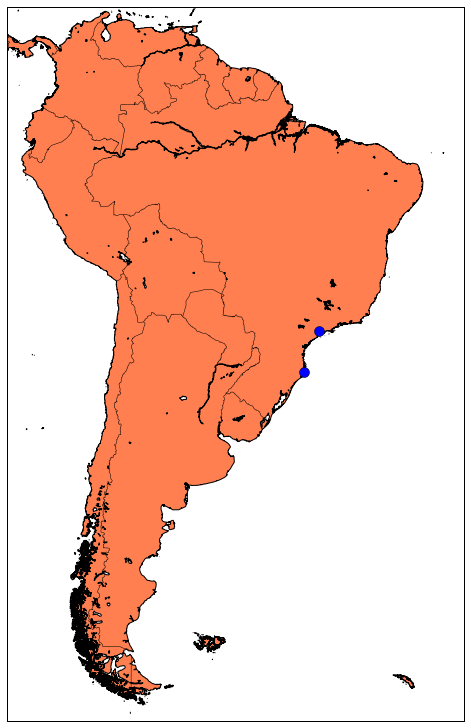

In [64]:
map = Basemap(projection='merc', lat_0 = -22, lon_0 = -56.5,resolution = 'h', area_thresh = 0.1, 
              llcrnrlon=-83.0, llcrnrlat=-57.0, urcrnrlon=-30.0, urcrnrlat=13.0)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=10)

plt.show()

Zoom em uma coordenada:

In [65]:
def gmap(lat,lon,zoom=10):
    # Google Maps URL template for an iframe
    google_maps_url = "http://maps.google.com/maps?q={0}+{1}&ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(lat,lon,zoom)
    display(IFrame(google_maps_url, '800px', '600px'))

In [66]:
gmap(lats[0],lons[0],4)

#### Graphs

http://networkx.lanl.gov/  

In [67]:
def get_rt_origins(tweet):
    ''' Regex adapted from 
    http://stackoverflow.com/questions/655903/python-regular-expression-for-retweets'''
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_origins = []
    try:
        rt_origins += [mention.strip() for mention in rt_patterns.findall(tweet)[0][1].split()]
    except IndexError as e:
        pass
    return [rto.strip("@") for rto in rt_origins]

In [68]:
def create_graph_retweets(tweets):
    g = nx.DiGraph()
    for tweet in tweets:
        rt_origins = get_rt_origins(tweet.text)
        if not rt_origins:
            continue
        for rt_origin in rt_origins:
            g.add_edge(rt_origin, tweet.user.screen_name, {'tweet_id': tweet.id})
    return g

In [69]:
g_rt = create_graph_retweets(tweets)
print("Number of nodes is: {}\n".format(g_rt.number_of_nodes()))
print("Number of edges is: {}\n".format(g_rt.number_of_edges()))

Number of nodes is: 63

Number of edges is: 36



In [70]:
import operator
sorted_dic = sorted(g_rt.degree().items(), key=operator.itemgetter(1), reverse=True)
sorted_dic

[('CloydRivers', 5),
 ('WeLoveRobDyrdek', 2),
 ('WORIDSTARHIPH0P', 2),
 ('voxdotcom', 2),
 ('TheKozforUSA', 2),
 ('WORLDSTARC0MEDY', 2),
 ('shopnca', 1),
 ('TIME', 1),
 ('EgoAnglus', 1),
 ('DeportIllegalss', 1),
 ('brianstelter', 1),
 ('TheSistaKrista', 1),
 ('DeplorableATL', 1),
 ('nickgourevitch', 1),
 ('FriendlyJMC', 1),
 ('MissusLaBrie', 1),
 ('jrwilberg', 1),
 ('LindaSuhler', 1),
 ('bella90skid', 1),
 ('MiroBlaze', 1),
 ('MissLizzyNJ', 1),
 ('Chelseaa__k', 1),
 ('zachflynn12', 1),
 ('Hillary4TheWin', 1),
 ('CorissaJustice', 1),
 ('citizenjo', 1),
 ('BIackPpIComedy', 1),
 ('adog634', 1),
 ('TheWoodzick', 1),
 ('HoodBibIe', 1),
 ('RlDICULOUSNESS', 1),
 ('benkaldwurse', 1),
 ('KellyannePolls:', 1),
 ('jimmycovington', 1),
 ('DailyNewsBin', 1),
 ('WeOfThePeopleR1', 1),
 ('hogball19', 1),
 ('Rodwellhotrod', 1),
 ('TeresaEdelglass', 1),
 ('KatrinaStengel', 1),
 ('Thomas1774Paine', 1),
 ('Mageester2', 1),
 ('VickiV7', 1),
 ('BigGGraphics', 1),
 ('BlackPplVines', 1),
 ('Justinwolf794', 1)

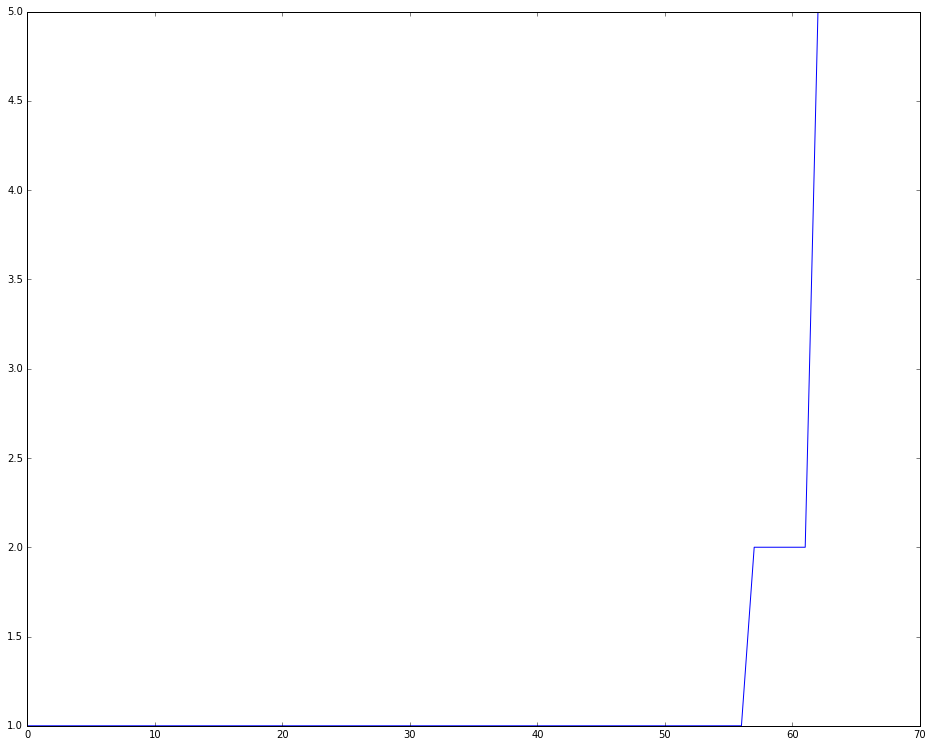

In [71]:
dic = nx.degree(g_rt)
plt.plot(sorted(dic.values()))

In [72]:
def save_dotfile(g):
    try:
        nx.drawing.write_dot(g, pathdotfile)
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
    except (ImportError, UnicodeEncodeError, AttributeError): 
        # Este bloco serve para usuarios de windows, que certamente terao problemas
        # com o metodo nx.drawing.write_dot. Tambem serve para os casos em que temos
        # problemas com o unicode
        dot = [u'"{}" -> "{}" [tweet_id={}]'.format(n1, n2, g[n1][n2]['tweet_id']) for (n1, n2) in g.edges()]
        f = codecs.open(pathdotfile, 'w', encoding='utf-8')
        f.write('''strict digraph {{}}'''.format(';\n'.join(dot), ))
        f.close()
        print(sys.stderr, 'Graph exported for file: {}'.format(pathdotfile))
        return f.name

In [73]:
save_dotfile(g_rt)

<ipykernel.iostream.OutStream object at 0x7fbab77179b0> Graph exported for file: ../outputs/graph_retweet.dot


'../outputs/graph_retweet.dot'

Saving a dotfile

Obs: To generate a png graph from the dotfile, type in the Unix Prompt: 
'circo -Tpng -Gcharset=latin1 -Ograph_retweet graph_retweet.dot'

In [74]:
#Chamando um programa externo ao Ipython com o operador !
!dot -Tpng ../outputs/graph_retweet.dot -o ../outputs/graph_retweet.png
Image(pathpngfile)

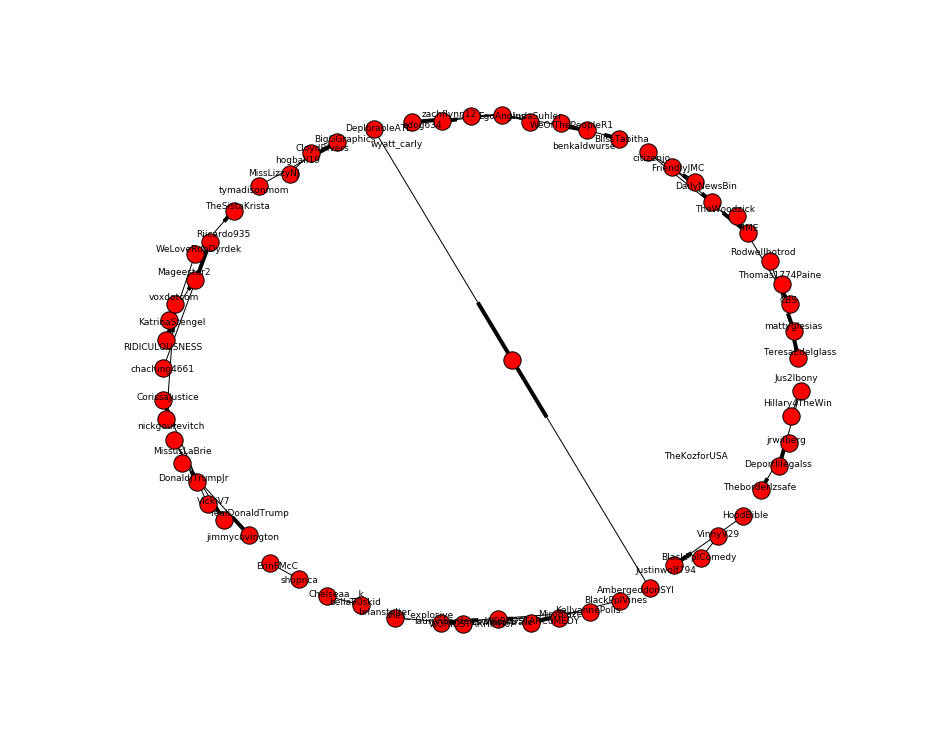

In [75]:
nx.draw_networkx_labels(g_rt,pos=nx.spring_layout(g_rt),font_size=9)
nx.draw(g_rt)
#nx.draw_random(g_rt)
#nx.draw_circular(g_rt)
#nx.draw_spectral(g_rt)

Saving a HTML file that uses javascript for visualizing the graph (needs a template)

In [76]:
def save_protovis_file(g):
    '''A visualization alternative is "protovis" javascript
    It uses the files "template_protoviz.html and "protovis-r3.2.js"
    '''
    nodes = g.nodes()
    indexed_nodes = {}
    idx = 0
    for n in nodes:
        indexed_nodes.update([(n, idx,)])
        idx += 1
    links = []
    for n1, n2 in g.edges():
        links.append({'source': indexed_nodes[n2],'target': indexed_nodes[n1]})
    json_data = json.dumps({"nodes" : [{"nodeName" : n} for n in nodes], "links" : links}, indent=4)
    html = open(pathtemplate).read().format(json_data,)
    f = open(pathprotofile, 'w')
    f.write(html)
    f.close()
    print(sys.stderr, 'Graph exported for file: {}'.format(pathprotofile))
    return f.name, html

In [77]:
s = save_protovis_file(g_rt)

<ipykernel.iostream.OutStream object at 0x7fbab77179b0> Graph exported for file: ../outputs/graph_retweet.html


In [78]:
#!chromium ../outputs/graph_retweet.html
# http://docs.python.org/library/webbrowser.html 

webbrowser.open(pathprotofile)

True

Exploring the GeoViews package  
https://www.continuum.io/blog/developer-blog/introducing-geoviews

In [81]:
#https://github.com/SciTools/Cartopy
#https://github.com/ioam/geoviews

import xarray as xr
import holoviews as hv
import geoviews as gv
import iris
import cartopy

from cartopy import crs
from cartopy import feature as cf
from geoviews import feature as gf

hv.notebook_extension('bokeh','matplotlib')
%output backend='matplotlib'
%opts Feature [projection=crs.Robinson()]

ImportError: No module named 'cartopy'